In [173]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from jupyter_core.migrate import regex

np.random.seed(42)


In [174]:
w = pd.read_csv("day15_real_dataset_large.csv")

In [175]:
a=w.copy()
print(a)

        age    income     city       signup_time
0        30   55000.0       NY        2024-01-01
1       NaN   70000.0       SF        2024-01-05
2        45       NaN       LA        not a date
3   unknown  120000.0       NY        2024/02/01
4        28   65000.0  Chicago        2024-01-15
..      ...       ...      ...               ...
92       26   52000.0      Jax        2024/08/25
93  unknown   68000.0       FW        08-28-2024
94      NaN   83000.0   Austin        2024-09-01
95       43       NaN       SF        2024/09/03
96       35   75000.0       NY  September 5 2024

[97 rows x 4 columns]


In [176]:
def clean_types(a):
    a["age"]=pd.to_numeric(a["age"],errors="coerce")
    a['income']=pd.to_numeric(a['income'],errors="coerce")
    a["signup_time"]=pd.to_datetime(a['signup_time'],errors="coerce")


In [177]:
clean_types(a)
print(a)

     age    income     city signup_time
0   30.0   55000.0       NY  2024-01-01
1    NaN   70000.0       SF  2024-01-05
2   45.0       NaN       LA         NaT
3    NaN  120000.0       NY         NaT
4   28.0   65000.0  Chicago  2024-01-15
..   ...       ...      ...         ...
92  26.0   52000.0      Jax         NaT
93   NaN   68000.0       FW         NaT
94   NaN   83000.0   Austin  2024-09-01
95  43.0       NaN       SF         NaT
96  35.0   75000.0       NY         NaT

[97 rows x 4 columns]


In [178]:
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   age          69 non-null     float64       
 1   income       77 non-null     float64       
 2   city         96 non-null     object        
 3   signup_time  42 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 3.2+ KB


In [179]:
a.isnull().sum()

age            28
income         20
city            1
signup_time    55
dtype: int64

In [180]:
def clean_missing(a):
    a["age"]=a['age'].fillna(a['age'].median())
    a["income"]=a['income'].fillna(a['income'].mean())
    a['city']=a['city'].fillna(a['city'].mode()[0])
    a["signup_time"]=a['signup_time'].fillna(a['signup_time'].mode()[0])
    a.loc[a["age"] < 0, "age"] = np.nan


In [181]:
clean_missing(a)
print(a)

     age         income     city signup_time
0   30.0   55000.000000       NY  2024-01-01
1   35.0   70000.000000       SF  2024-01-05
2   45.0   77077.922078       LA  2024-01-01
3   35.0  120000.000000       NY  2024-01-01
4   28.0   65000.000000  Chicago  2024-01-15
..   ...            ...      ...         ...
92  26.0   52000.000000      Jax  2024-01-01
93  35.0   68000.000000       FW  2024-01-01
94  35.0   83000.000000   Austin  2024-09-01
95  43.0   77077.922078       SF  2024-01-01
96  35.0   75000.000000       NY  2024-01-01

[97 rows x 4 columns]


In [182]:
def handle_outliers(a):
    def l(p: pd.Series, lower_q=0.01, upper_q=0.99) -> pd.Series:
        lower, upper = p.quantile(lower_q), p.quantile(upper_q)
        return p.clip(lower=lower, upper=upper)
    a["income"]=l(a['income'])
    a["age"]=l(a['age'])
    return a

In [183]:
handle_outliers(a)
print(a)

     age         income     city signup_time
0   30.0   55000.000000       NY  2024-01-01
1   35.0   70000.000000       SF  2024-01-05
2   45.0   77077.922078       LA  2024-01-01
3   35.0  115200.000000       NY  2024-01-01
4   28.0   65000.000000  Chicago  2024-01-15
..   ...            ...      ...         ...
92  26.0   52000.000000      Jax  2024-01-01
93  35.0   68000.000000       FW  2024-01-01
94  35.0   83000.000000   Austin  2024-09-01
95  43.0   77077.922078       SF  2024-01-01
96  35.0   75000.000000       NY  2024-01-01

[97 rows x 4 columns]


In [184]:
def clean_strings_and_dates(a):
    a["city"] = (
        a["city"]
        .str.lower()
        .str.replace("-", " ", regex=False)
        .str.replace(r"[^a-z\s]", "", regex=True)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )
    city_map = {
        "ny": "new york",
        "nyc": "new york",
        "sf": "san francisco",
        "la": "los angeles"
    }
    a["city"] = a["city"].replace(city_map)
    return a

In [185]:
clean_strings_and_dates(a)
print(a)

     age         income           city signup_time
0   30.0   55000.000000       new york  2024-01-01
1   35.0   70000.000000  san francisco  2024-01-05
2   45.0   77077.922078    los angeles  2024-01-01
3   35.0  115200.000000       new york  2024-01-01
4   28.0   65000.000000        chicago  2024-01-15
..   ...            ...            ...         ...
92  26.0   52000.000000            jax  2024-01-01
93  35.0   68000.000000             fw  2024-01-01
94  35.0   83000.000000         austin  2024-09-01
95  43.0   77077.922078  san francisco  2024-01-01
96  35.0   75000.000000       new york  2024-01-01

[97 rows x 4 columns]


In [186]:
def validate_cleaned(a):
 assert a["age"].min() >= 0, "Negative ages found"
 assert a["income"].notna().all(), "Income still has NaN"
 assert a["city"].notna().all(), "City still has NaN"


In [187]:
validate_cleaned(a)
print(a)

     age         income           city signup_time
0   30.0   55000.000000       new york  2024-01-01
1   35.0   70000.000000  san francisco  2024-01-05
2   45.0   77077.922078    los angeles  2024-01-01
3   35.0  115200.000000       new york  2024-01-01
4   28.0   65000.000000        chicago  2024-01-15
..   ...            ...            ...         ...
92  26.0   52000.000000            jax  2024-01-01
93  35.0   68000.000000             fw  2024-01-01
94  35.0   83000.000000         austin  2024-09-01
95  43.0   77077.922078  san francisco  2024-01-01
96  35.0   75000.000000       new york  2024-01-01

[97 rows x 4 columns]


In [188]:
a.isna().sum()

age            4
income         0
city           0
signup_time    0
dtype: int64

In [189]:
def clean_data_project(a):
    clean_types(a)
    clean_missing(a)
    clean_strings_and_dates(a)
    handle_outliers(a)
    validate_cleaned(a)
    return a


In [190]:
clean_data_project(a)
print(a)

     age         income           city signup_time
0   30.0   55000.000000       new york  2024-01-01
1   35.0   70000.000000  san francisco  2024-01-05
2   45.0   77077.922078    los angeles  2024-01-01
3   35.0  115008.000000       new york  2024-01-01
4   28.0   65000.000000        chicago  2024-01-15
..   ...            ...            ...         ...
92  26.0   52000.000000            jax  2024-01-01
93  35.0   68000.000000             fw  2024-01-01
94  35.0   83000.000000         austin  2024-09-01
95  43.0   77077.922078  san francisco  2024-01-01
96  35.0   75000.000000       new york  2024-01-01

[97 rows x 4 columns]


In [191]:
a.info()
a.describe()
a["city"].value_counts().head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   age          97 non-null     float64       
 1   income       97 non-null     float64       
 2   city         97 non-null     object        
 3   signup_time  97 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 3.2+ KB


city
new york         6
san francisco    4
los angeles      3
austin           3
boston           2
Name: count, dtype: int64

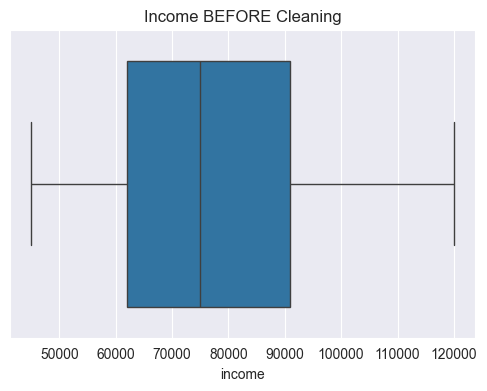

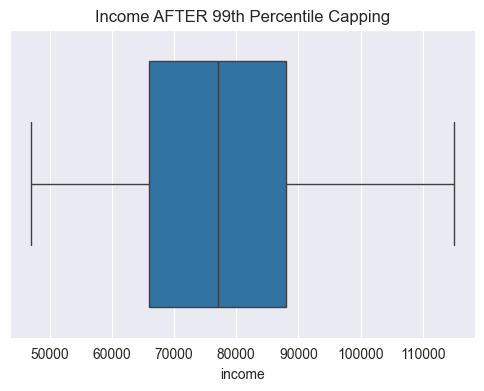

In [192]:
plt.figure(figsize=(6,4))
sns.boxplot(x=w["income"])
plt.title("Income BEFORE Cleaning")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=a["income"])
plt.title("Income AFTER 99th Percentile Capping")
plt.show()


In [193]:
a.to_csv("day15_cleaned_dataset.csv", index=False)
